In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [130]:
Final = pd.read_csv('data.csv',parse_dates = ['date'])

In [131]:
Final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 9 columns):
Month         120 non-null int64
Price         120 non-null float64
Change        120 non-null float64
Production    120 non-null int64
year          120 non-null int64
Weather       120 non-null float64
oilPrice      120 non-null float64
date          120 non-null datetime64[ns]
goldPrice     120 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(3)
memory usage: 8.5 KB


In [132]:
Final.head()

,Month,Price,Change,Production,year,Weather,oilPrice,date,goldPrice
0,5,261.48,0.00,60117,2009,64.7,57.30,2009-05-01,926.855
1,6,256.64,-1.85,60117,2009,74.8,68.61,2009-06-01,947.807
2,7,224.85,-12.39,60117,2009,73.5,64.44,2009-07-01,934.272
3,8,210.37,-6.44,60117,2009,74.0,72.51,2009-08-01,949.500
4,9,191.09,-9.16,60117,2009,67.0,67.65,2009-09-01,996.443


In [133]:
import pandas as pd
import seaborn as sns
import time
import math
from datetime import date
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook
from xgboost import XGBRegressor

%matplotlib inline

#### Input params ##################
test_size = 0.2              # proportion of dataset to be used as test set
cv_size = 0.2                  # proportion of dataset to be used as cross-validation set
# N = 2                         # for feature at day t, we use lags from t-1, t-2, ..., t-N as features

n_estimators = 100             # Number of boosted trees to fit. default = 100
max_depth = 3                  # Maximum tree depth for base learners. default = 3
learning_rate = 0.1            # Boosting learning rate (xgb’s “eta”). default = 0.1
min_child_weight = 1           # Minimum sum of instance weight(hessian) needed in a child. default = 1
subsample = 1                  # Subsample ratio of the training instance. default = 1
colsample_bytree = 1           # Subsample ratio of columns when constructing each tree. default = 1
colsample_bylevel = 1          # Subsample ratio of columns for each split, in each level. default = 1
gamma = 0                      # Minimum loss reduction required to make a further partition on a leaf node of the tree. default=0

model_seed = 100

fontsize = 14
ticklabelsize = 14

In [184]:
def get_mov_avg_std(df, col, N):
    """
    Given a dataframe, get mean and std dev at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe. Can be of any length.
        col        : name of the column you want to calculate mean and std dev
        N          : get mean and std dev at timestep t using values from t-1, t-2, ..., t-N
    Outputs
        df_out     : same as df but with additional column containing mean and std dev
    """
    mean_list = df[col].rolling(window = N, min_periods=1).mean() # len(mean_list) = len(df)
    std_list = df[col].rolling(window = N, min_periods=1).std()   # first value will be NaN, because normalized by N-1
    
    # Add one timestep to the predictions
    mean_list = np.concatenate((np.array([np.nan]), np.array(mean_list[:-1])))
    std_list = np.concatenate((np.array([np.nan]), np.array(std_list[:-1])))
    
    # Append mean_list to df
    df_out = df.copy()
    df_out[col + '_mean'+ str(N)] = mean_list
    df_out[col + '_std'+ str(N)] = std_list
    
    return df_out

def scale_row(row, feat_mean, feat_std):
    """
    Given a pandas series in row, scale it to have 0 mean and var 1 using feat_mean and feat_std
    Inputs
        row      : pandas series. Need to scale this.
        feat_mean: mean  
        feat_std : standard deviation
    Outputs
        row_scaled : pandas series with same length as row, but scaled
    """
    # If feat_std = 0 (this happens if adj_close doesn't change over N days), 
    # set it to a small number to avoid division by zero
    feat_std = 0.001 if feat_std == 0 else feat_std
    
    row_scaled = (row-feat_mean) / feat_std
    
    return row_scaled

def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def train_pred_eval_model(X_train_scaled, \
                          y_train_scaled, \
                          X_test_scaled, \
                          y_test, \
                          seed=100, \
                          n_estimators=100, \
                          max_depth=3, \
                          learning_rate=0.1, \
                          min_child_weight=1, \
                          subsample=1, \
                          colsample_bytree=1, \
                          colsample_bylevel=1, \
                          gamma=0):
    '''
    Train model, do prediction, scale back to original range and do evaluation
    Use XGBoost here.
    Inputs
        X_train_scaled     : features for training. Scaled to have mean 0 and variance 1
        y_train_scaled     : target for training. Scaled to have mean 0 and variance 1
        X_test_scaled      : features for test. Each sample is scaled to mean 0 and variance 1
        y_test             : target for test. Actual values, not scaled.
        col_mean           : means used to scale each sample of X_test_scaled. Same length as X_test_scaled and y_test
        col_std            : standard deviations used to scale each sample of X_test_scaled. Same length as X_test_scaled and y_test
        seed               : model seed
        n_estimators       : number of boosted trees to fit
        max_depth          : maximum tree depth for base learners
        learning_rate      : boosting learning rate (xgb’s “eta”)
        min_child_weight   : minimum sum of instance weight(hessian) needed in a child
        subsample          : subsample ratio of the training instance
        colsample_bytree   : subsample ratio of columns when constructing each tree
        colsample_bylevel  : subsample ratio of columns for each split, in each level
        gamma              : 
    Outputs
        rmse               : root mean square error of y_test and est
        mape               : mean absolute percentage error of y_test and est
        est                : predicted values. Same length as y_test
    '''

    model = XGBRegressor(seed=model_seed,
                         n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree,
                         colsample_bylevel=colsample_bylevel,
                         gamma=gamma)
    
    # Train the model
    model.fit(X_train_scaled, y_train_scaled)
    
    # Get predicted labels and scale back to original range
    est_scaled = model.predict(X_test_scaled)
    est = np.expm1(est_scaled) 

    # Calculate RMSE
    rmse = math.sqrt(mean_squared_error(y_test, est))
    mape = get_mape(y_test, est)
    
    return rmse, mape, est

In [166]:
gold = Final[['date','Month','year','goldPrice']]
gold = gold.rename(columns={"goldPrice": "Price"})
wheat = Final[['date','Month','year','Price']]
oil = Final[['date','Month','year','oilPrice']]
oil = oil.rename(columns={"oilPrice": "Price"})

In [167]:

gold = get_mov_avg_std(gold,'Price', 2)
gold = get_mov_avg_std(gold,'Price', 6)
gold = get_mov_avg_std(gold,'Price', 12)
gold

,date,Month,year,Price,Price_mean2,Price_std2,Price_mean6,Price_std6,Price_mean12,Price_std12
0,2009-05-01,5,2009,926.855,NaN,NaN,NaN,NaN,NaN,NaN
1,2009-06-01,6,2009,947.807,926.8550,NaN,926.855000,NaN,926.855000,NaN
2,2009-07-01,7,2009,934.272,937.3310,14.815301,937.331000,14.815301,937.331000,14.815301
3,2009-08-01,8,2009,949.500,941.0395,9.570690,936.311333,10.623829,936.311333,10.623829
4,2009-09-01,9,2009,996.443,941.8860,10.767822,939.608500,10.896286,939.608500,10.896286
5,2009-10-01,10,2009,1043.511,972.9715,33.193714,950.975400,27.112338,950.975400,27.112338
6,2009-11-01,11,2009,1126.119,1019.9770,33.282102,966.398000,44.891008,966.398000,44.891008
7,2009-12-01,12,2009,1135.012,1084.8150,58.412677,999.608667,74.034414,989.215286,72.963931
8,2010-01-01,1,2010,1119.575,1130.5655,6.288301,1030.809500,86.273020,1007.439875,84.972271
9,2010-02-01,2,2010,1095.800,1127.2935,10.915607,1061.693333,77.526935,1019.899333,87.834469


In [168]:
df = gold
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 10 columns):
date            120 non-null datetime64[ns]
Month           120 non-null int64
year            120 non-null int64
Price           120 non-null float64
Price_mean2     119 non-null float64
Price_std2      118 non-null float64
Price_mean6     119 non-null float64
Price_std6      118 non-null float64
Price_mean12    119 non-null float64
Price_std12     118 non-null float64
dtypes: datetime64[ns](1), float64(7), int64(2)
memory usage: 9.5 KB


In [169]:
# Get sizes of each of the datasets
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train]
cv = df[num_train:num_train+num_cv]
train_cv = df[:num_train+num_cv]
test = df[num_train+num_cv:]
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))
train_cv.head()

num_train = 72
num_cv = 24
num_test = 24
train.shape = (72, 10)
cv.shape = (24, 10)
train_cv.shape = (96, 10)
test.shape = (24, 10)


,date,Month,year,Price,Price_mean2,Price_std2,Price_mean6,Price_std6,Price_mean12,Price_std12
0,2009-05-01,5,2009,926.855,NaN,NaN,NaN,NaN,NaN,NaN
1,2009-06-01,6,2009,947.807,926.8550,NaN,926.855000,NaN,926.855000,NaN
2,2009-07-01,7,2009,934.272,937.3310,14.815301,937.331000,14.815301,937.331000,14.815301
3,2009-08-01,8,2009,949.500,941.0395,9.570690,936.311333,10.623829,936.311333,10.623829
4,2009-09-01,9,2009,996.443,941.8860,10.767822,939.608500,10.896286,939.608500,10.896286


In [170]:
cv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 72 to 95
Data columns (total 10 columns):
date            24 non-null datetime64[ns]
Month           24 non-null int64
year            24 non-null int64
Price           24 non-null float64
Price_mean2     24 non-null float64
Price_std2      24 non-null float64
Price_mean6     24 non-null float64
Price_std6      24 non-null float64
Price_mean12    24 non-null float64
Price_std12     24 non-null float64
dtypes: datetime64[ns](1), float64(7), int64(2)
memory usage: 2.0 KB


In [171]:
x_train, y_train = train.drop(columns = ['Price','date']), np.log1p(train['Price'])
x_cv, y_cv = cv.drop(columns = ['Price','date']), np.log1p(cv['Price'])
x_train_cv, y_train_cv = train_cv.drop(columns = ['Price','date']), np.log1p(train_cv['Price'])
x_sample, y_sample = test.drop(columns = ['Price','date']), np.log1p(test['Price'])

# Split into X and y
print("X_train.shape = " + str(x_train.shape))
print("y_train.shape = " + str(y_train.shape))
print("X_cv.shape = " + str(x_cv.shape))
print("y_cv.shape = " + str(y_cv.shape))
print("X_train_cv.shape = " + str(x_train_cv.shape))
print("y_train_cv.shape = " + str(y_train_cv.shape))
print("X_sample.shape = " + str(x_sample.shape))
print("y_sample.shape = " + str(y_sample.shape))

X_train.shape = (72, 8)
y_train.shape = (72,)
X_cv.shape = (24, 8)
y_cv.shape = (24,)
X_train_cv.shape = (96, 8)
y_train_cv.shape = (96,)
X_sample.shape = (24, 8)
y_sample.shape = (24,)


In [172]:
y_train.head()

0    6.832875
1    6.855205
2    6.840837
3    6.856988
4    6.905195
Name: Price, dtype: float64

In [173]:
train.head().append(train.tail())

,date,Month,year,Price,Price_mean2,Price_std2,Price_mean6,Price_std6,Price_mean12,Price_std12
0,2009-05-01,5,2009,926.855,NaN,NaN,NaN,NaN,NaN,NaN
1,2009-06-01,6,2009,947.807,926.8550,NaN,926.855000,NaN,926.855000,NaN
2,2009-07-01,7,2009,934.272,937.3310,14.815301,937.331000,14.815301,937.331000,14.815301
3,2009-08-01,8,2009,949.500,941.0395,9.570690,936.311333,10.623829,936.311333,10.623829
4,2009-09-01,9,2009,996.443,941.8860,10.767822,939.608500,10.896286,939.608500,10.896286
67,2014-12-01,12,2014,1200.440,1199.9890,33.341499,1254.859833,50.991006,1268.098000,46.578337
68,2015-01-01,1,2015,1249.333,1188.4265,16.989655,1241.957000,53.729253,1266.335667,48.843080
69,2015-02-01,2,2015,1231.100,1224.8865,34.572572,1231.347667,41.875234,1266.857750,48.604664
70,2015-03-01,3,2015,1180.636,1240.2165,12.892678,1220.363500,27.323764,1261.223333,48.495030
71,2015-04-01,4,2015,1198.253,1205.8680,35.683437,1210.247833,29.181022,1248.229667,47.349885


In [174]:
cv.head().append(cv.tail())

,date,Month,year,Price,Price_mean2,Price_std2,Price_mean6,Price_std6,Price_mean12,Price_std12
72,2015-05-01,5,2015,1197.684,1189.4445,12.457100,1206.029167,28.696364,1239.819500,46.432352
73,2015-06-01,6,2015,1182.248,1197.9685,0.402344,1209.574333,25.434314,1232.217083,45.113256
74,2015-07-01,7,2015,1131.580,1189.9660,10.914900,1206.542333,27.722395,1224.249667,44.761403
75,2015-08-01,8,2015,1117.525,1156.9140,35.827686,1186.916833,32.619027,1209.132250,42.650778
76,2015-09-01,9,2015,1124.905,1124.5525,9.938386,1167.987667,34.736721,1194.175583,40.447298
91,2016-12-01,12,2016,1152.165,1254.6110,20.248710,1297.951667,42.384536,1241.174500,86.283596
92,2017-01-01,1,2017,1192.648,1196.2290,62.315906,1277.715833,73.736131,1248.161833,73.454098
93,2017-02-01,2,2017,1233.390,1172.4065,28.625804,1253.585667,73.976171,1256.244583,59.076246
94,2017-03-01,3,2017,1231.063,1213.0190,28.808944,1235.673833,60.379215,1259.452667,56.427624
95,2017-04-01,4,2017,1267.150,1232.2265,1.645437,1219.748000,41.126325,1258.181917,56.920010


In [175]:
test.head().append(test.tail())

,date,Month,year,Price,Price_mean2,Price_std2,Price_mean6,Price_std6,Price_mean12,Price_std12
96,2017-05-01,5,2017,1245.250,1249.1065,25.517362,1219.451500,40.705097,1260.323417,56.716413
97,2017-06-01,6,2017,1261.277,1256.2000,15.485639,1220.277667,41.259238,1259.114667,56.883948
98,2017-07-01,7,2017,1235.100,1253.2635,11.332800,1238.463000,26.717019,1258.089417,56.710136
99,2017-08-01,8,2017,1281.720,1248.1885,18.509934,1245.538333,15.368337,1249.562000,51.112689
100,2017-09-01,9,2017,1317.045,1258.4100,32.965318,1253.593333,19.764422,1244.633583,43.843456
115,2018-12-01,12,2018,1249.887,1218.0005,4.630842,1226.208000,30.808999,1271.168167,54.566510
116,2019-01-01,1,2019,1291.630,1235.5810,20.231739,1220.834833,20.033068,1269.852583,54.900304
117,2019-02-01,2,2019,1319.755,1270.7585,29.516758,1229.762500,35.336981,1266.421000,51.807259
118,2019-03-01,3,2019,1302.286,1305.6925,19.887378,1249.411833,47.427793,1265.252667,50.285989
119,2019-04-01,4,2019,1287.650,1311.0205,12.352448,1266.593167,44.158888,1263.313000,48.151835


Text(0.5, 1.0, 'Without scaling')

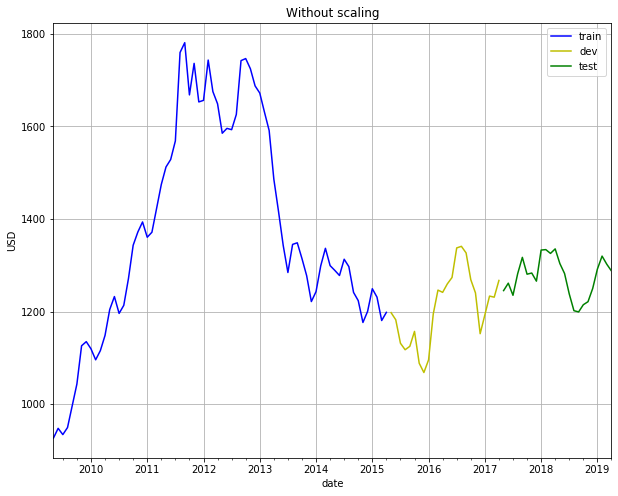

In [176]:
%matplotlib inline
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='Price', style='b-', grid=True)
ax = cv.plot(x='date', y='Price', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='Price', style='g-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_title("Without scaling")

Text(0.5, 1.0, 'With scaling')

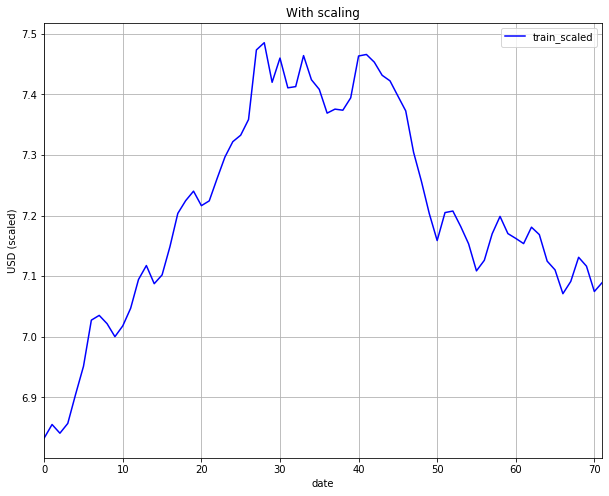

In [177]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = y_train.plot(x='date', y='Price', style='b-', grid=True)
ax.legend(['train_scaled'])
ax.set_xlabel("date")
ax.set_ylabel("USD (scaled)")
ax.set_title("With scaling")

In [178]:
# Create the model
model = XGBRegressor(seed=model_seed,
                     n_estimators=n_estimators,
                     max_depth=max_depth,
                     learning_rate=learning_rate,
                     min_child_weight=min_child_weight,
                     subsample=subsample,
                     colsample_bytree=colsample_bytree,
                     colsample_bylevel=colsample_bylevel,
                     gamma=gamma)

# Train the regressor
model.fit(x_train, y_train)

[16:41:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=100,
             silent=None, subsample=1, verbosity=1)

In [179]:
# Do prediction on train set
est_scaled = model.predict(x_train)
est = np.expm1(est_scaled) 

# Calculate RMSE
print("RMSE on train set = %0.3f" % math.sqrt(mean_squared_error(np.expm1(y_train), est)))

# Calculate MAPE
print("MAPE on train set = %0.3f%%" % get_mape(np.expm1(y_train), est))

RMSE on train set = 10.167
MAPE on train set = 0.580%


Text(0.5, 1.0, 'Without scaling')

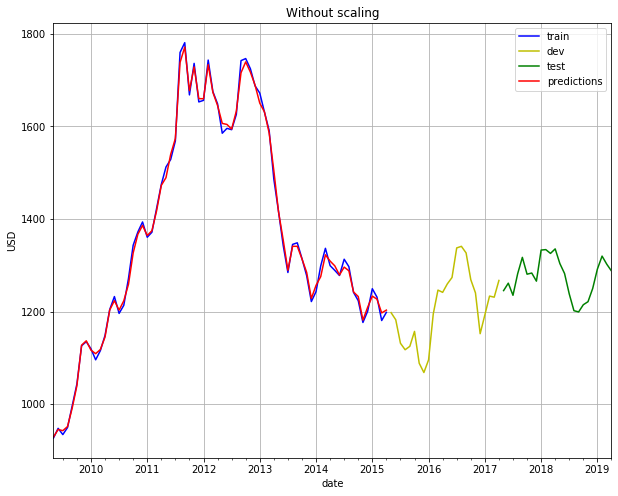

In [180]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'date': train['date']})

ax = train.plot(x='date', y='Price', style='b-', grid=True)
ax = cv.plot(x='date', y='Price', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='Price', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_title('Without scaling')

RMSE on dev set = 56.955
MAPE on dev set = 4.044%


Text(0, 0.5, 'USD')

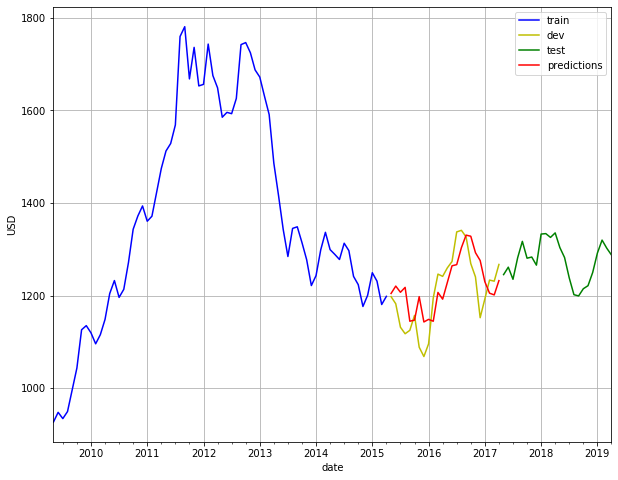

In [181]:
# Do prediction on test set
est_scaled = model.predict(x_cv)
cv['est'] = np.expm1(est_scaled)
y_cv = np.expm1(y_cv)

# Calculate RMSE
rmse_bef_tuning = math.sqrt(mean_squared_error(y_cv, cv['est']))
print("RMSE on dev set = %0.3f" % rmse_bef_tuning)

# Calculate MAPE
mape_bef_tuning = get_mape(y_cv, cv['est'])
print("MAPE on dev set = %0.3f%%" % mape_bef_tuning)
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': cv['est'], 
                       'y_cv': y_cv,
                       'date': cv['date']})

ax = train.plot(x='date', y='Price', style='b-', grid=True)
ax = cv.plot(x='date', y='Price', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='Price', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to dev set')

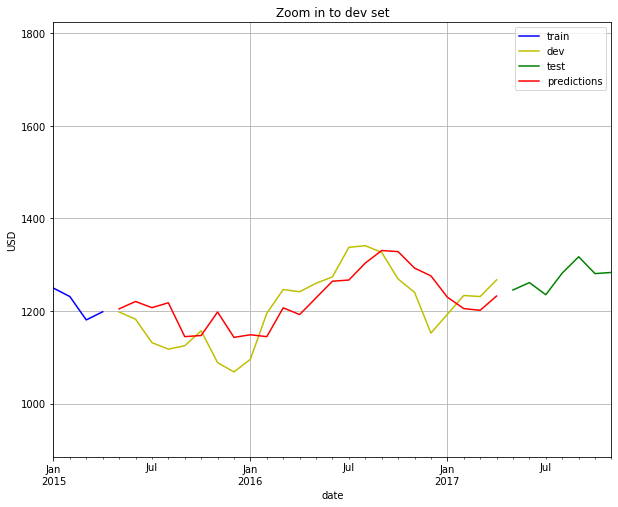

In [182]:
# Plot adjusted close over time, for dev set only
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ax = train.plot(x='date', y='Price', style='b-', grid=True)
ax = cv.plot(x='date', y='Price', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='Price', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2015, 1, 1), date(2017, 11, 1)])
ax.set_title("Zoom in to dev set")

# Features importance

In [183]:
# View a list of the features and their importance scores
imp = list(zip(train, model.feature_importances_))
imp.sort(key=lambda tup: tup[1]) 
imp[-10:]

[('date', 0.005830355),
 ('Price', 0.0078849895),
 ('Price_mean6', 0.011604423),
 ('Price_std2', 0.016359525),
 ('Price_std6', 0.017496992),
 ('Price_mean2', 0.050746813),
 ('Month', 0.060366318),
 ('year', 0.8297106)]

In [191]:
param_label = 'n_estimators'
param_list = range(2, 100, 2)

param2_label = 'max_depth'
param2_list = [7, 8, 9]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(x_train, 
                                     y_train, 
                                     x_cv, 
                                     y_cv, 
                                     seed=model_seed,
                                     n_estimators=param, 
                                     max_depth=param2, 
                                     learning_rate=learning_rate, 
                                     min_child_weight=min_child_weight, 
                                     subsample=subsample, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=gamma)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

[16:52:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:52:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:52:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:52:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:52:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:52:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:52:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:52:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:52:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[16:52:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:52:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:52:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:52:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:52:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:52:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:52:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:52:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:52:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

,n_estimators,max_depth,rmse,mape_pct
0,2,7,1204.733481,99.600612
1,2,8,1204.733481,99.600612
2,2,9,1204.733481,99.600612
3,4,7,1194.433289,98.742040
4,4,8,1194.433289,98.742040
5,4,9,1194.433289,98.742040
6,6,7,1173.608452,97.006093
7,6,8,1173.608452,97.006093
8,6,9,1173.608452,97.006093
9,8,7,1138.046364,94.041346


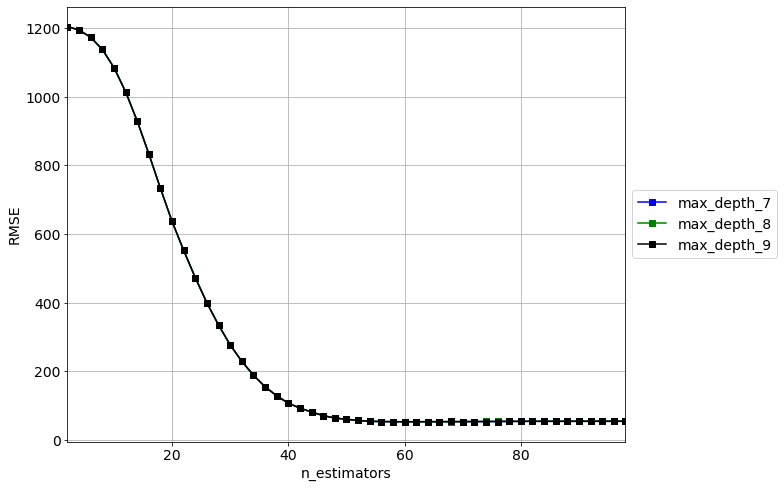

In [192]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
plt.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [193]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
n_estimators_opt = temp['n_estimators'].values[0]
max_depth_opt = temp['max_depth'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
n_estimators_opt, max_depth_opt

min RMSE = 52.635
optimum params = 


(64, 8)

In [194]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['n_estimators'].values[0], temp['max_depth'].values[0]

min MAPE = 3.586%
optimum params = 


(98, 9)

In [200]:
param_label = 'learning_rate'
param_list = [0.005, 0.01, 0.05, 0.1, 0.2, 0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.7,0.8,0.9,1]

param2_label = 'min_child_weight'
param2_list = range(1, 30, 1)

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(x_train, 
                                     y_train, 
                                     x_cv, 
                                     y_cv, 
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=param, 
                                     min_child_weight=param2, 
                                     subsample=subsample, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=gamma)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

[16:57:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:57:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:57:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:57:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:57:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:57:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:57:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:57:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:57:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[16:57:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:57:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:57:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:57:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:57:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:57:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:57:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:57:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:57:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[16:57:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:57:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:57:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:57:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:57:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:57:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:57:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:57:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:57:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[16:57:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:57:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:57:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:57:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:57:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:57:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:57:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:57:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:57:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[16:57:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:57:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:57:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:57:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:57:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:57:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:57:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:57:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:57:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[16:57:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:57:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:57:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:57:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:57:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:57:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:57:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:57:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:57:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[16:57:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:57:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:57:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:57:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:57:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:57:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:57:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Minutes taken = 0.10904924869537354


,learning_rate,min_child_weight,rmse,mape_pct
0,0.005,1,1200.372370,99.237095
1,0.005,2,1200.372370,99.237095
2,0.005,3,1200.372370,99.237095
3,0.005,4,1200.372370,99.237095
4,0.005,5,1200.372370,99.237095
5,0.005,6,1200.372370,99.237095
6,0.005,7,1200.372370,99.237095
7,0.005,8,1200.372370,99.237095
8,0.005,9,1200.372370,99.237095
9,0.005,10,1200.372370,99.237095


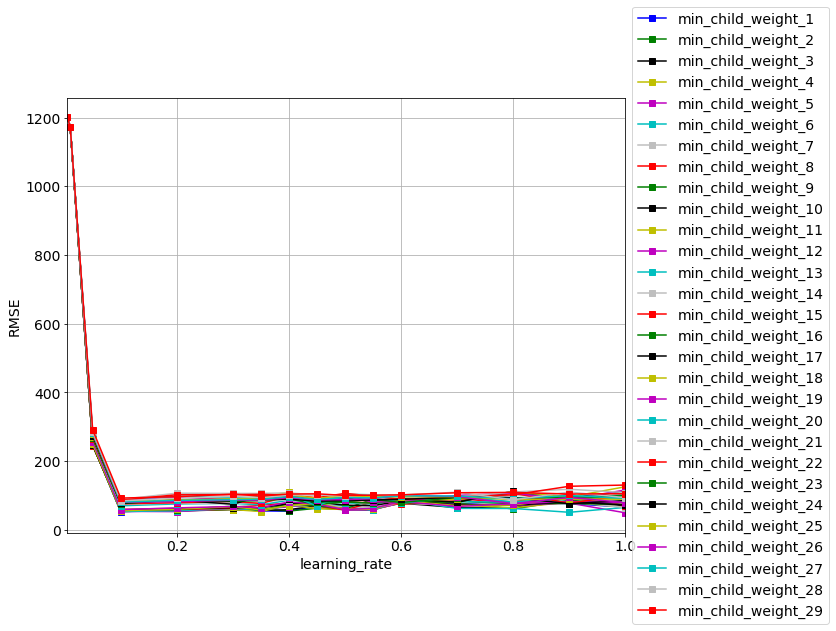

In [201]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
plt.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [202]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
learning_rate_opt = temp['learning_rate'].values[0]
min_child_weight_opt = temp['min_child_weight'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
learning_rate_opt, min_child_weight_opt

min RMSE = 49.046
optimum params = 


(1.0, 5)

In [203]:
# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['learning_rate'].values[0], temp['min_child_weight'].values[0]

min MAPE = 3.163%
optimum params = 


(1.0, 5)

In [209]:
param_label = 'subsample'
param_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'gamma'
param2_list = [0,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(x_train, 
                                     y_train, 
                                     x_cv, 
                                     y_cv, 
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=learning_rate_opt, 
                                     min_child_weight=min_child_weight_opt, 
                                     subsample=param, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=param2)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

[16:59:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:59:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:59:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:59:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:59:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:59:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:59:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:59:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:59:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[16:59:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:59:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:59:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:59:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:59:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:59:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:59:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:59:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:59:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

,subsample,gamma,rmse,mape_pct
0,0.1,0.0,233.190130,14.701408
1,0.1,0.1,106.795119,7.142774
2,0.1,0.2,82.187634,5.630955
3,0.1,0.3,206.553589,16.358303
4,0.1,0.4,206.553589,16.358303
5,0.1,0.5,206.553589,16.358303
6,0.1,0.6,206.553589,16.358303
7,0.1,0.7,206.553589,16.358303
8,0.1,0.8,206.553589,16.358303
9,0.1,0.9,206.553589,16.358303


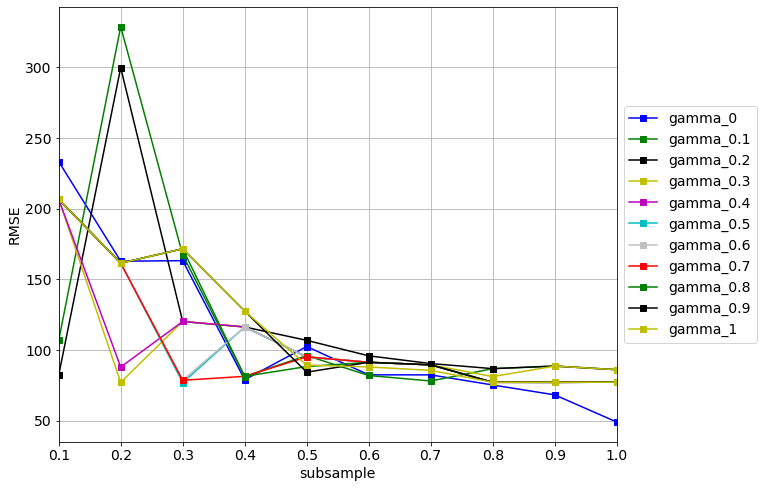

In [210]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
plt.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [211]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
subsample_opt = temp['subsample'].values[0]
gamma_opt = temp['gamma'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
subsample_opt, gamma_opt

min RMSE = 49.046
optimum params = 


(1.0, 0.0)

In [212]:
# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['subsample'].values[0], temp['gamma'].values[0]

min MAPE = 3.163%
optimum params = 


(1.0, 0.0)

In [213]:
param_label = 'colsample_bytree'
param_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'colsample_bylevel'
param2_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(x_train, 
                                     y_train, 
                                     x_cv, 
                                     y_cv, 
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=learning_rate_opt, 
                                     min_child_weight=min_child_weight_opt, 
                                     subsample=subsample_opt, 
                                     colsample_bytree=param, 
                                     colsample_bylevel=param2, 
                                     gamma=gamma_opt)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

[16:59:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:59:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:59:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:59:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:59:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:59:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:59:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:59:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:59:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

,colsample_bytree,colsample_bylevel,rmse,mape_pct
0,0.5,0.5,177.392943,11.256665
1,0.5,0.6,177.392943,11.256665
2,0.5,0.7,177.392943,11.256665
3,0.5,0.8,128.392795,8.832449
4,0.5,0.9,128.392795,8.832449
5,0.5,1.0,59.658178,3.676987
6,0.6,0.5,177.392943,11.256665
7,0.6,0.6,177.392943,11.256665
8,0.6,0.7,177.392943,11.256665
9,0.6,0.8,128.392795,8.832449


In [214]:
d = {'param': ['n_estimators', 'max_depth', 'learning_rate', 'min_child_weight', 'subsample', 'gamma', 'rmse', 'mape_pct'],
     'original': [n_estimators, max_depth, learning_rate, min_child_weight, subsample, gamma, rmse_bef_tuning, mape_bef_tuning],
     'after_tuning': [n_estimators_opt, max_depth_opt, learning_rate_opt, min_child_weight_opt, subsample_opt, gamma_opt, error_rate['rmse'].min(), error_rate['mape_pct'].min()]}
tuned_params = pd.DataFrame(d)
tuned_params = tuned_params.round(3)
tuned_params

,param,original,after_tuning
0,n_estimators,100.000,64.000
1,max_depth,3.000,8.000
2,learning_rate,0.100,1.000
3,min_child_weight,1.000,5.000
4,subsample,1.000,1.000
5,gamma,0.000,0.000
6,rmse,56.955,49.046
7,mape_pct,4.044,3.163


In [215]:
n_estimators_opt

64

[17:01:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE on dev set = 49.046
MAPE on dev set = 3.163%


Text(0, 0.5, 'USD')

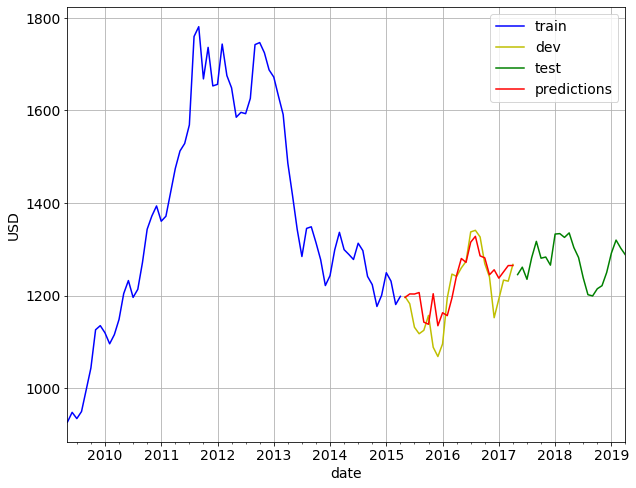

In [217]:
# Create the model
model = XGBRegressor(seed=model_seed,
                             n_estimators=n_estimators, 
                             max_depth=max_depth_opt, 
                             learning_rate=learning_rate_opt, 
                             min_child_weight=min_child_weight_opt, 
                             subsample=subsample_opt, 
                             gamma=gamma_opt)

# Train the regressor
model.fit(x_train, y_train)
# Do prediction on test set
est_scaled = model.predict(x_cv)
cv['est'] = np.expm1(est_scaled)


# Calculate RMSE
rmse_bef_tuning = math.sqrt(mean_squared_error(y_cv, cv['est']))
print("RMSE on dev set = %0.3f" % rmse_bef_tuning)

# Calculate MAPE
mape_bef_tuning = get_mape(y_cv, cv['est'])
print("MAPE on dev set = %0.3f%%" % mape_bef_tuning)
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': cv['est'], 
                       'y_cv': y_cv,
                       'date': cv['date']})

ax = train.plot(x='date', y='Price', style='b-', grid=True)
ax = cv.plot(x='date', y='Price', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='Price', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [219]:
rmse, mape, est = train_pred_eval_model(x_train_cv, 
                             y_train_cv, 
                             x_sample, 
                             y_sample,
                             seed=model_seed,
                             n_estimators=n_estimators, 
                             max_depth=max_depth_opt, 
                             learning_rate=learning_rate_opt, 
                             min_child_weight=min_child_weight_opt, 
                             subsample=subsample_opt, 
                             gamma=gamma_opt)

# Calculate RMSE
print("RMSE on test set = %0.3f" % rmse)

# Calculate MAPE
print("MAPE on test set = %0.3f%%" % mape)

[17:02:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE on test set = 1233.256
MAPE on test set = 17239.597%


Text(0, 0.5, 'USD')

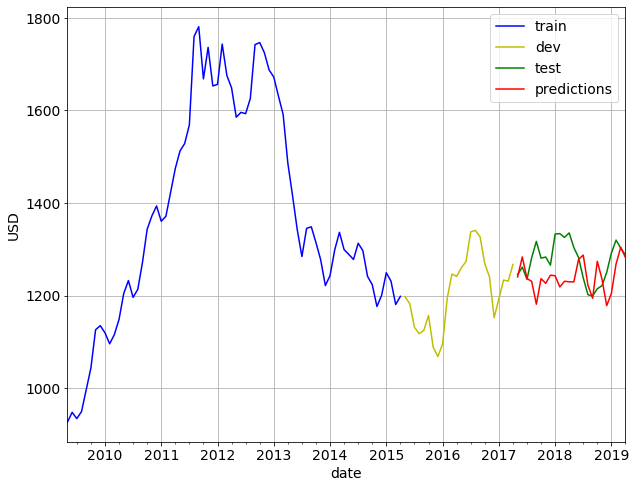

In [220]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'y_sample': y_sample,
                       'date': test['date']})

ax = train.plot(x='date', y='Price', style='b-', grid=True)
ax = cv.plot(x='date', y='Price', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='Price', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to test set')

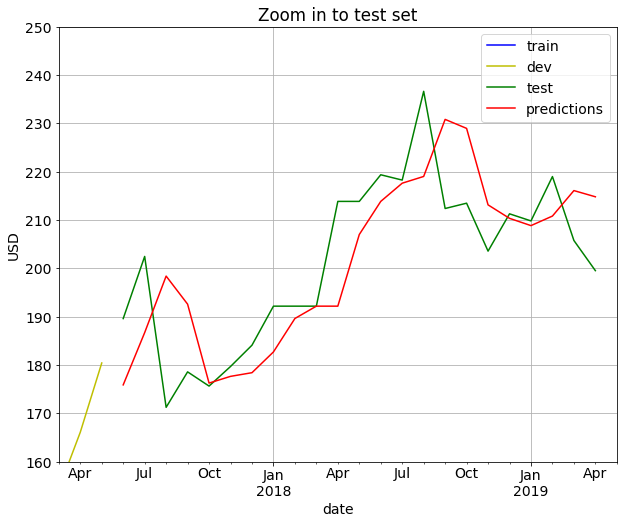

In [89]:
# Plot adjusted close over time, for test set only
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ax = train.plot(x='date', y='Price', style='b-', grid=True)
ax = cv.plot(x='date', y='Price', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='Price', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2017, 3, 1), date(2019, 5, 1)])
ax.set_ylim([160, 250])
ax.set_title("Zoom in to test set")

(566, 592)

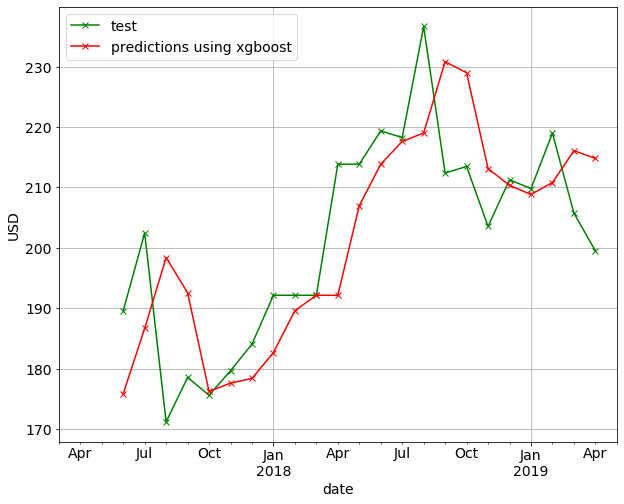

In [90]:
# Plot adjusted close over time, only for test set
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
plt.rcParams.update({'font.size': 14})

ax = test.plot(x='date', y='Price', style='gx-', grid=True)
ax = est_df.plot(x='date', y='est', style='rx-', grid=True, ax=ax)
ax.legend(['test', 'predictions using xgboost'], loc='upper left')
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2017, 3, 1), date(2019, 5, 1)])

In [91]:
rmse,mape

(12.234561957845612, 4.831594786112913)

In [92]:
from sklearn.linear_model import Lasso
lasso_opt = Lasso(alpha =55 ,max_iter = 1000)
lasso_opt.fit(X_train, y_train)
est = lasso_opt.predict(X_sample)
rmse = math.sqrt(mean_squared_error(y_sample, est))
mape = get_mape(y_sample, est)
rmse,mape

(13.946199565649598, 5.4803993276688825)

Text(0, 0.5, 'USD')

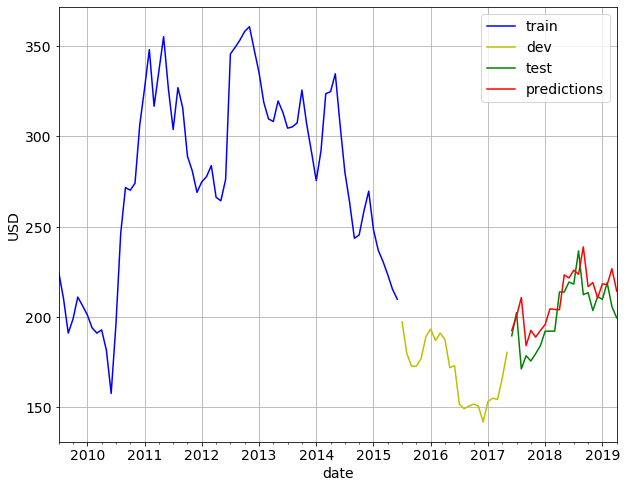

In [93]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'y_sample': y_sample,
                       'date': test['date']})

ax = train.plot(x='date', y='Price', style='b-', grid=True)
ax = cv.plot(x='date', y='Price', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='Price', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

(566, 592)

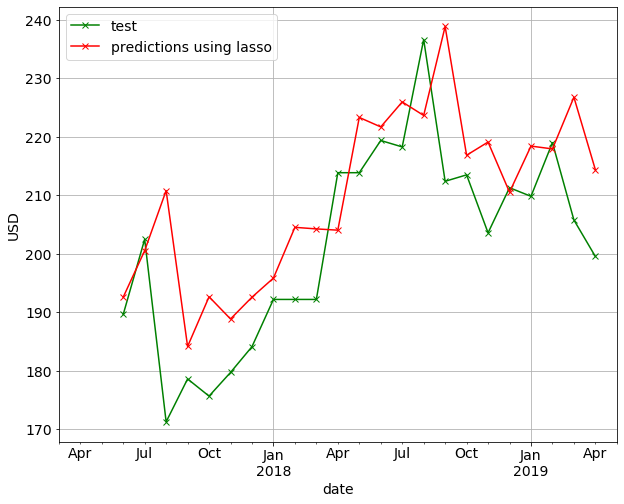

In [94]:
# Plot adjusted close over time, only for test set
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
plt.rcParams.update({'font.size': 14})

ax = test.plot(x='date', y='Price', style='gx-', grid=True)
ax = est_df.plot(x='date', y='est', style='rx-', grid=True, ax=ax)
ax.legend(['test', 'predictions using lasso'], loc='upper left')
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2017, 3, 1), date(2019, 5, 1)])

In [95]:
from sklearn.linear_model import Lasso
lasso_opt = Lasso(alpha =55 ,max_iter = 1000)
lasso_opt.fit(X_train, y_train)
est = lasso_opt.predict(X_cv)
rmse = math.sqrt(mean_squared_error(y_cv, est))
mape = get_mape(y_cv, est)
rmse,mape

(16.172630342556563, 8.416292635559971)

Text(0, 0.5, 'USD')

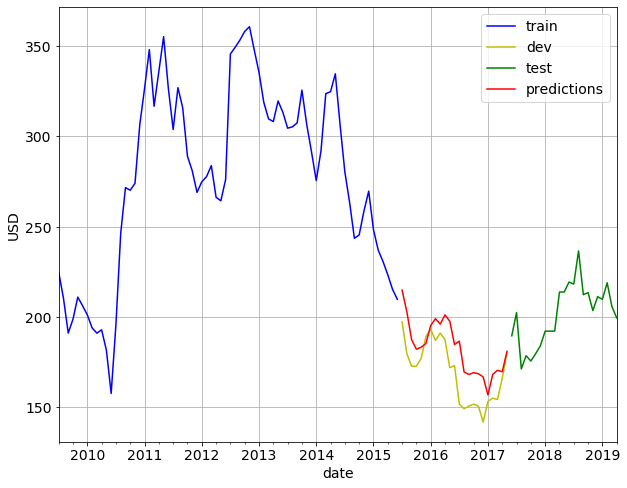

In [96]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'y_cv': y_cv,
                       'date': cv['date']})

ax = train.plot(x='date', y='Price', style='b-', grid=True)
ax = cv.plot(x='date', y='Price', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='Price', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

(542, 570)

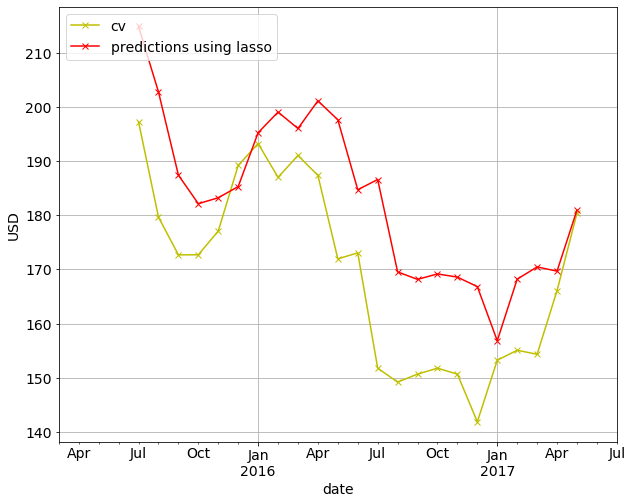

In [97]:
# Plot adjusted close over time, only for test set
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
plt.rcParams.update({'font.size': 14})

ax = cv.plot(x='date', y='Price', style='yx-', grid=True)
ax = est_df.plot(x='date', y='est', style='rx-', grid=True, ax=ax)
ax.legend(['cv', 'predictions using lasso'], loc='upper left')
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2015, 3, 1), date(2017, 7, 1)])

In [98]:
from sklearn.linear_model import ElasticNet
regr = ElasticNet(random_state=0)
regr.fit(X_train, y_train)
est = regr.predict(X_sample)
rmse = math.sqrt(mean_squared_error(y_sample, est))
mape = get_mape(y_sample, est)
rmse,mape

(14.145476910646236, 5.560837101249772)

(566, 592)

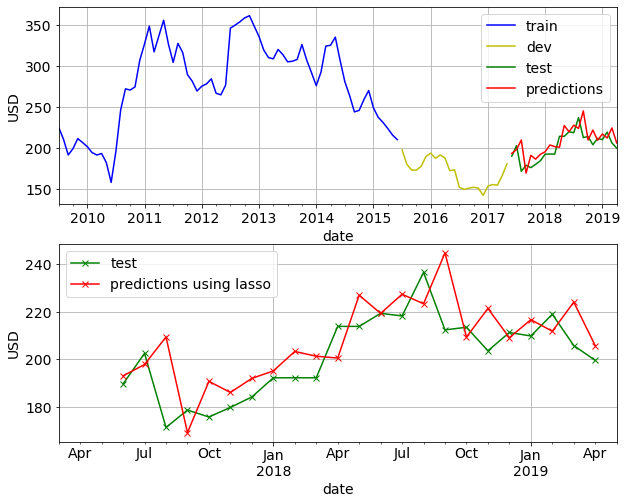

In [99]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
fig, (ax1, ax2) = plt.subplots(2,1)
est_df = pd.DataFrame({'est': est, 
                       'y_sample': y_sample,
                       'date': test['date']})

ax1 = train.plot(x='date', y='Price', style='b-', grid=True ,ax=ax1)
ax1 = cv.plot(x='date', y='Price', style='y-', grid=True, ax=ax1)
ax1 = test.plot(x='date', y='Price', style='g-', grid=True, ax=ax1)
ax1 = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax1)
ax1.legend(['train', 'dev', 'test', 'predictions'])
ax1.set_xlabel("date")
ax1.set_ylabel("USD")

rcParams['figure.figsize'] = 10, 8 # width 10, height 8
plt.rcParams.update({'font.size': 14})

ax2 = test.plot(x='date', y='Price', style='gx-', grid=True, ax=ax2)
ax2 = est_df.plot(x='date', y='est', style='rx-', grid=True, ax=ax2)
ax2.legend(['test', 'predictions using lasso'], loc='upper left')
ax2.set_xlabel("date")
ax2.set_ylabel("USD")
ax2.set_xlim([date(2017, 3, 1), date(2019, 5, 1)])



In [100]:
def train_pred_eval_model(X_train_scaled, \
                          y_train_scaled, \
                          X_test_scaled, \
                          y_test, \
                          col_mean, \
                          col_std, \
                          alpha=1, \
                          max_iter=1000, \
                          l1_ratio=0.5):
    '''
    Train model, do prediction, scale back to original range and do evaluation
    Use XGBoost here.
    Inputs
        X_train_scaled     : features for training. Scaled to have mean 0 and variance 1
        y_train_scaled     : target for training. Scaled to have mean 0 and variance 1
        X_test_scaled      : features for test. Each sample is scaled to mean 0 and variance 1
        y_test             : target for test. Actual values, not scaled.
        col_mean           : means used to scale each sample of X_test_scaled. Same length as X_test_scaled and y_test
        col_std            : standard deviations used to scale each sample of X_test_scaled. Same length as X_test_scaled and y_test
        seed               : model seed
        n_estimators       : number of boosted trees to fit
        max_depth          : maximum tree depth for base learners
        learning_rate      : boosting learning rate (xgb’s “eta”)
        min_child_weight   : minimum sum of instance weight(hessian) needed in a child
        subsample          : subsample ratio of the training instance
        colsample_bytree   : subsample ratio of columns when constructing each tree
        colsample_bylevel  : subsample ratio of columns for each split, in each level
        gamma              : 
    Outputs
        rmse               : root mean square error of y_test and est
        mape               : mean absolute percentage error of y_test and est
        est                : predicted values. Same length as y_test
    '''

    model = ElasticNet(alpha=alpha,l1_ratio=l1_ratio,max_iter=max_iter,random_state=0)
    
    # Train the model
    model.fit(X_train_scaled, y_train_scaled)
    
    # Get predicted labels and scale back to original range
    est_scaled = model.predict(X_test_scaled)
    est = est_scaled * col_std + col_mean

    # Calculate RMSE
    rmse = math.sqrt(mean_squared_error(y_test, est))
    mape = get_mape(y_test, est)
    
    return rmse, mape, est

In [101]:
param_label = 'alpha'
param_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

param2_label = 'l1_ratio'
param2_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]



error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['Price_mean'],
                                     cv['Price_std'],
                                     alpha=param, 
                                     l1_ratio=param2)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   


Minutes taken = 0.005787964661916097


,alpha,l1_ratio,rmse,mape_pct
0,0.1,0.1,13.492325,6.056109
1,0.1,0.2,13.435860,6.018780
2,0.1,0.3,13.436730,6.016460
3,0.1,0.4,13.458842,6.027452
4,0.1,0.5,13.481400,6.038427
5,0.1,0.6,13.508324,6.047817
6,0.1,0.7,13.538964,6.058844
7,0.1,0.8,13.582507,6.073089
8,0.1,0.9,13.632730,6.089065
9,0.1,1.0,13.686952,6.103081


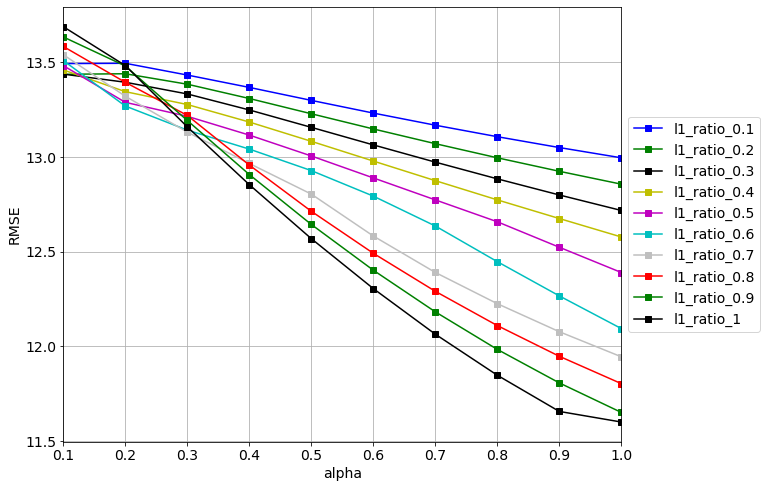

In [102]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
plt.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [103]:
rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['Price_mean'],
                                     cv['Price_std'],
                                     alpha=1, 
                                     max_iter=1000,
                                     l1_ratio=1)
rmse, mape

(11.60153728569208, 5.364916897527676)